In this Notebook, we'll explore data from Lyft that was provided in the "3d-object-detection-for-autonomous-vehicles" (https://www.kaggle.com/competitions/3d-object-detection-for-autonomous-vehicles/overview) Kaggle competition. Of the two data modalities provided (imagery and lidar point clouds), we will only be using imagery. Our goal is to explore i. Image classification and ii. Object Detection. While I could have chosen data from an origin that had exactly these tasks in mind (MNIST, CIFAR etc), I thought it would make the exploration more difficult and realistic by taking data not already tailored to the use case. 

After some general preprocessing work, we will split our exploration into two phases: Phase 1 will be Image Classification and Phase 2 Will be Object Detection. Within each phase, we will do additional preprocessing steps that are required for the task, and will further break up the phases into sections where we will use pretrained models imported from Pytorch and then try our hand at creating a more simplistic corresponding model by hand.

# Imports and inital data read.

In [2]:
import json
import os
from pathlib import Path
from PIL import Image
import numpy as np
import random
import time

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import models, ops
from torchvision.models import resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset

# With our Data Processing finished, we now shift to create and train our models.

In [2]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 8.3 seconds.
Reverse indexing ...
Done reverse indexing in 2.6 seconds.


# Define our custom Dataset classes for image classification and object detection.

In [3]:
class Lyft_image_classification_CustomDataset(Dataset):
    def __init__(self, cropped_images_dir, target_category_name, required_size=224):
        self.cropped_images_dir = cropped_images_dir
        self.required_size = required_size
        self.image_filenames = os.listdir(cropped_images_dir)
        self.data = []
        #Our class will ingest cropped images from all categories. We must add corresponding labels to these images.
        #The images are stored in directories wrt their category. So, we use the dir name to label the image.
        #Iterate over each subdirectory in the main directory
        for category_folder in os.listdir(cropped_images_dir):
            category_dir = os.path.join(cropped_images_dir, category_folder)
            if os.path.isdir(category_dir):  # Check if it's a directory
                category_name = category_folder.split("_")[0]
                is_target_category = category_name == target_category_name
                label = 1 if is_target_category else 0

                for filename in os.listdir(category_dir):
                    file_path = os.path.join(category_dir, filename)
                    if os.path.isfile(file_path):  # Check if it's a file
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        # Convert the image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

In [4]:
# Define a function for default transformations. It is convention to not define transforms in the Dataset class.
def default_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class Lyft_binary_object_detection_CustomDataset(Dataset):
    def __init__(self, data_dict, images_base_path, transform=None, random_sample = None, positive_imgs_only = False):
        """
        Args:
            data_dict (dict): Dictionary containing image file paths and corresponding bounding box and label data. IMPORTANT: This expects labels of 1 or 0 as input.
            transform (callable, optional): Optional transform to be applied on a sample.
            random_sample (float, optional): Fraction of the dataset to use. If None, the entire dataset is used.

        """
        self.images_base_path = images_base_path
        self.transform = transform if transform else default_transform()
        self.data_dict = data_dict

        # If we only want to iterate over images we know have at least one instance of our positve class. This can reduce input and thus training time, but will decrease observed negative instances.
        # We don't specify the positive class here. It is assumed the "data_dict" comes with positive class == 1.
        if positive_imgs_only:
            positive_images = []
            for k, v in self.data_dict.items():
                labels = v["labels"]
                if any(labels):
                    positive_images.append(k)
            self.data_dict = {k: self.data_dict[k] for k in positive_images}

        # Regardless of if we or have not reduced input size with positive_imgs_only, (further) reduce the data by the percentage given.
        if random_sample:
            # Ensure random_sample is a valid fraction
            if not (0 < random_sample <= 1):
                raise ValueError("random_sample must be a decimal between 0 and 1.")

            # Randomly sample the specified fraction of data
            total_items = len(self.data_dict)
            sample_size = int(total_items * random_sample)
            sampled_items = random.sample(list(self.data_dict.items()), sample_size)
            self.data_dict = dict(sampled_items)

        self.file_names = self.data_dict.keys()



    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        image_name = list(self.data_dict.keys())[idx]
        image_path = os.path.join(self.images_base_path, image_name)
        image = Image.open(image_path)#.convert("RGB")  # Convert image to RGB
        # Convert the image to tensor and normalize (if transform is given)
        image = self.transform(image)


        # Retrieve boxes and labels for the image
        boxes = torch.as_tensor(self.data_dict[image_name]['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(self.data_dict[image_name]['labels'], dtype=torch.int64)

        # Ensure labels tensor is always 1D
        if len(labels.shape) == 0:
            labels = labels.unsqueeze(0)


        # Create a dictionary for the targets
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return image, target


# Read in our data with an instance of our Lyft_experimental_CustomDataset class.

### Each Dataset instance will instantiated with the model it will be given to in mind. For example, our ResNet model is designed for image classification where the full object is centered in the image.
### Conversely, the YOLO model will be used for object detection, and will be given images where the object is only partiall visible in some cases unlike our ResNet input.

In [9]:
cropped_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images\224'
dataset = Lyft_image_classification_CustomDataset(cropped_images_dir, target_category_name = "pedestrian", required_size=224)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("total number of batches to anticipate: ", len(dataset)/batch_size)

total number of batches to anticipate:  756.53125


#### Remind ourselves what dataloader actually is. It is a grouping of binary labels indicating target category and the corresponding images as tensors.

In [9]:
# for data in dataloader:
#     data_batch_tensor = data[0]
#     data_batch_label = data[1]
#     break

# print(len(data_batch_tensor), len(data_batch_label))
# print(data_batch_label[0])
# print(data_batch_tensor[0])

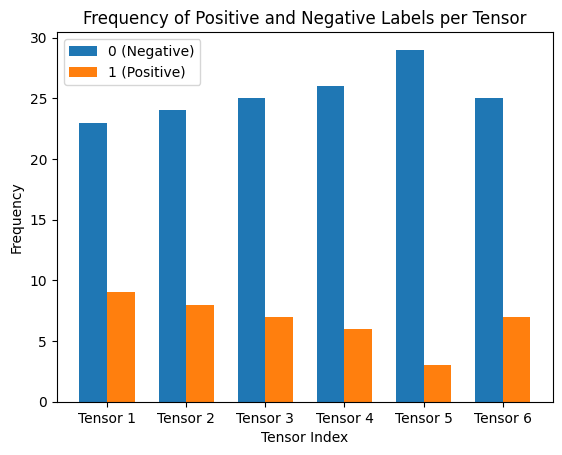

In [8]:
sample_labels = []
for i, data in enumerate(dataloader):
    # print(f"Batch {i}: Labels - {data[1]}")
    sample_labels.append(data[1])
    if i == 5:  # Check first 5 batches
        break

positives = [torch.sum(tensor == 1).item() for tensor in sample_labels]
negatives = [torch.sum(tensor == 0).item() for tensor in sample_labels]

n_tensors = len(sample_labels)
index = np.arange(n_tensors)
bar_width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(index, negatives, bar_width, label='0 (Negative)')
bar2 = ax.bar(index + bar_width, positives, bar_width, label='1 (Positive)')

ax.set_xlabel('Tensor Index')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Positive and Negative Labels per Tensor')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'Tensor {i+1}' for i in range(n_tensors)])
ax.legend()

plt.show()

# Image CLassificaiton 

## Import a ResNet50 model and train it on our images with the class object centered.

In [11]:
model_res50 = models.resnet50(pretrained=True)
num_ftrs = model_res50.fc.in_features
print(num_ftrs)
model_res50.fc = nn.Linear(num_ftrs, 2) # Modify the last layer for binary classification

c:\Users\stern\ytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stern\ytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048


#### Define loss function

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_res50.parameters(), lr=0.001)

#### Check if GPU is available and move the model to GPU if it is

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_res50 = model_res50.to(device)

cuda:0


## Train

In [14]:
# Number of epochs to train for
num_epochs = 10

for epoch in range(num_epochs):
    #Set training mode at beginning of each epoch in case we train on validation data within epoch with requires model.eval()
    model_res50.train()  # Set the model to training mode

    running_loss = 0.0
    running_corrects = 0
    running_true_positives = 0
    running_false_positives = 0
    running_false_negatives = 0

    # Iterate over data by batch
    for inputs, labels in dataloader:
        #Make sure input data and labels are on the GPU device.
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_res50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        # Assuming that loss.item() is the average loss of the predictions in the batch. Multiply by batch size to get the total loss (mean(loss)*batch_size).
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        # Calculate True Positives, False Positives, False Negatives
        for i in range(len(labels)):
            if preds[i] == labels[i] == 1:  # True Positive
                running_true_positives += 1
            elif preds[i] == 1 and labels[i] == 0:  # False Positive
                running_false_positives += 1
            elif preds[i] == 0 and labels[i] == 1:  # False Negative
                running_false_negatives += 1

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    # Calculate Precision, Recall, and F1 Score after the loop
    precision = running_true_positives / (running_true_positives + running_false_positives) if (running_true_positives + running_false_positives) > 0 else 0
    recall = running_true_positives / (running_true_positives + running_false_negatives) if (running_true_positives + running_false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1_score:.4f} Acc: {epoch_acc:.4f}')

    # # Assuming you have the final loss and accuracy in variables `final_loss` and `final_acc`
    # final_loss = 0.0303
    # final_acc = 0.9891

    # # Save the model state and metrics in a dictionary
    # checkpoint = {
    #     'model_state_dict': model_res50.state_dict(),
    #     'final_loss': final_loss,
    #     'final_accuracy': final_acc
    # }

    # # Save the checkpoint
    # torch.save(checkpoint, 'model_res50_checkpoint.pth')

    # # To load the model and metrics later
    # checkpoint = torch.load('model_res50_checkpoint.pth')
    # model_res50.load_state_dict(checkpoint['model_state_dict'])
    # loaded_final_loss = checkpoint['final_loss']
    # loaded_final_acc = checkpoint['final_accuracy']

Epoch 0/9 Loss: 0.1496 Precision: 0.8249 Recall: 0.8209 F1 Score: 0.8229 Acc: 0.9404
Epoch 1/9 Loss: 0.1039 Precision: 0.8757 Recall: 0.8948 F1 Score: 0.8851 Acc: 0.9608
Epoch 2/9 Loss: 0.0905 Precision: 0.8890 Recall: 0.9116 F1 Score: 0.9002 Acc: 0.9659
Epoch 3/9 Loss: 0.0798 Precision: 0.9031 Recall: 0.9212 F1 Score: 0.9120 Acc: 0.9700
Epoch 4/9 Loss: 0.0655 Precision: 0.9202 Recall: 0.9369 F1 Score: 0.9285 Acc: 0.9756
Epoch 5/9 Loss: 0.0665 Precision: 0.9147 Recall: 0.9347 F1 Score: 0.9246 Acc: 0.9743
Epoch 6/9 Loss: 0.0600 Precision: 0.9286 Recall: 0.9418 F1 Score: 0.9351 Acc: 0.9779
Epoch 7/9 Loss: 0.0541 Precision: 0.9342 Recall: 0.9449 F1 Score: 0.9395 Acc: 0.9795
Epoch 8/9 Loss: 0.0479 Precision: 0.9424 Recall: 0.9564 F1 Score: 0.9494 Acc: 0.9828
Epoch 9/9 Loss: 0.0422 Precision: 0.9493 Recall: 0.9586 F1 Score: 0.9540 Acc: 0.9844


In [15]:
torch.save(model_res50, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\resnet50_2023_11_28_00_28")

## Load the model we trained back into our Notbook after previously saving it.

In [16]:
model_res50 = torch.load(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\resnet50_2023_11_21_22_15")
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Visualize the output of the first layer which is a convolution layer with kernel 7x7. This is just to remind us what we are dealing with.

tensor([[[0.4760, 0.4743, 0.4661, 0.4955, 0.5031, 0.4722, 0.4078],
         [0.4549, 0.4583, 0.4736, 0.5090, 0.5175, 0.4930, 0.4511],
         [0.4549, 0.4578, 0.4556, 0.5131, 0.5559, 0.5352, 0.5052],
         [0.4458, 0.4449, 0.4122, 0.4309, 0.4550, 0.4880, 0.4916],
         [0.4411, 0.4677, 0.4452, 0.4304, 0.3853, 0.4004, 0.4419],
         [0.4417, 0.4869, 0.4927, 0.5223, 0.4753, 0.4100, 0.4144],
         [0.4181, 0.4639, 0.4738, 0.5290, 0.5222, 0.4761, 0.4490]],

        [[0.4667, 0.4824, 0.4985, 0.5539, 0.5650, 0.5308, 0.4546],
         [0.4587, 0.4801, 0.5151, 0.5860, 0.6175, 0.5998, 0.5558],
         [0.4292, 0.4116, 0.4039, 0.4862, 0.5737, 0.6037, 0.5906],
         [0.4195, 0.3754, 0.2920, 0.2714, 0.3157, 0.4213, 0.4813],
         [0.4701, 0.4662, 0.4027, 0.3180, 0.2336, 0.2634, 0.3562],
         [0.4962, 0.5463, 0.5501, 0.5535, 0.4620, 0.3612, 0.3520],
         [0.4673, 0.5338, 0.5726, 0.6424, 0.6185, 0.5381, 0.4710]],

        [[0.4642, 0.4702, 0.4877, 0.5323, 0.5415, 0.5142, 

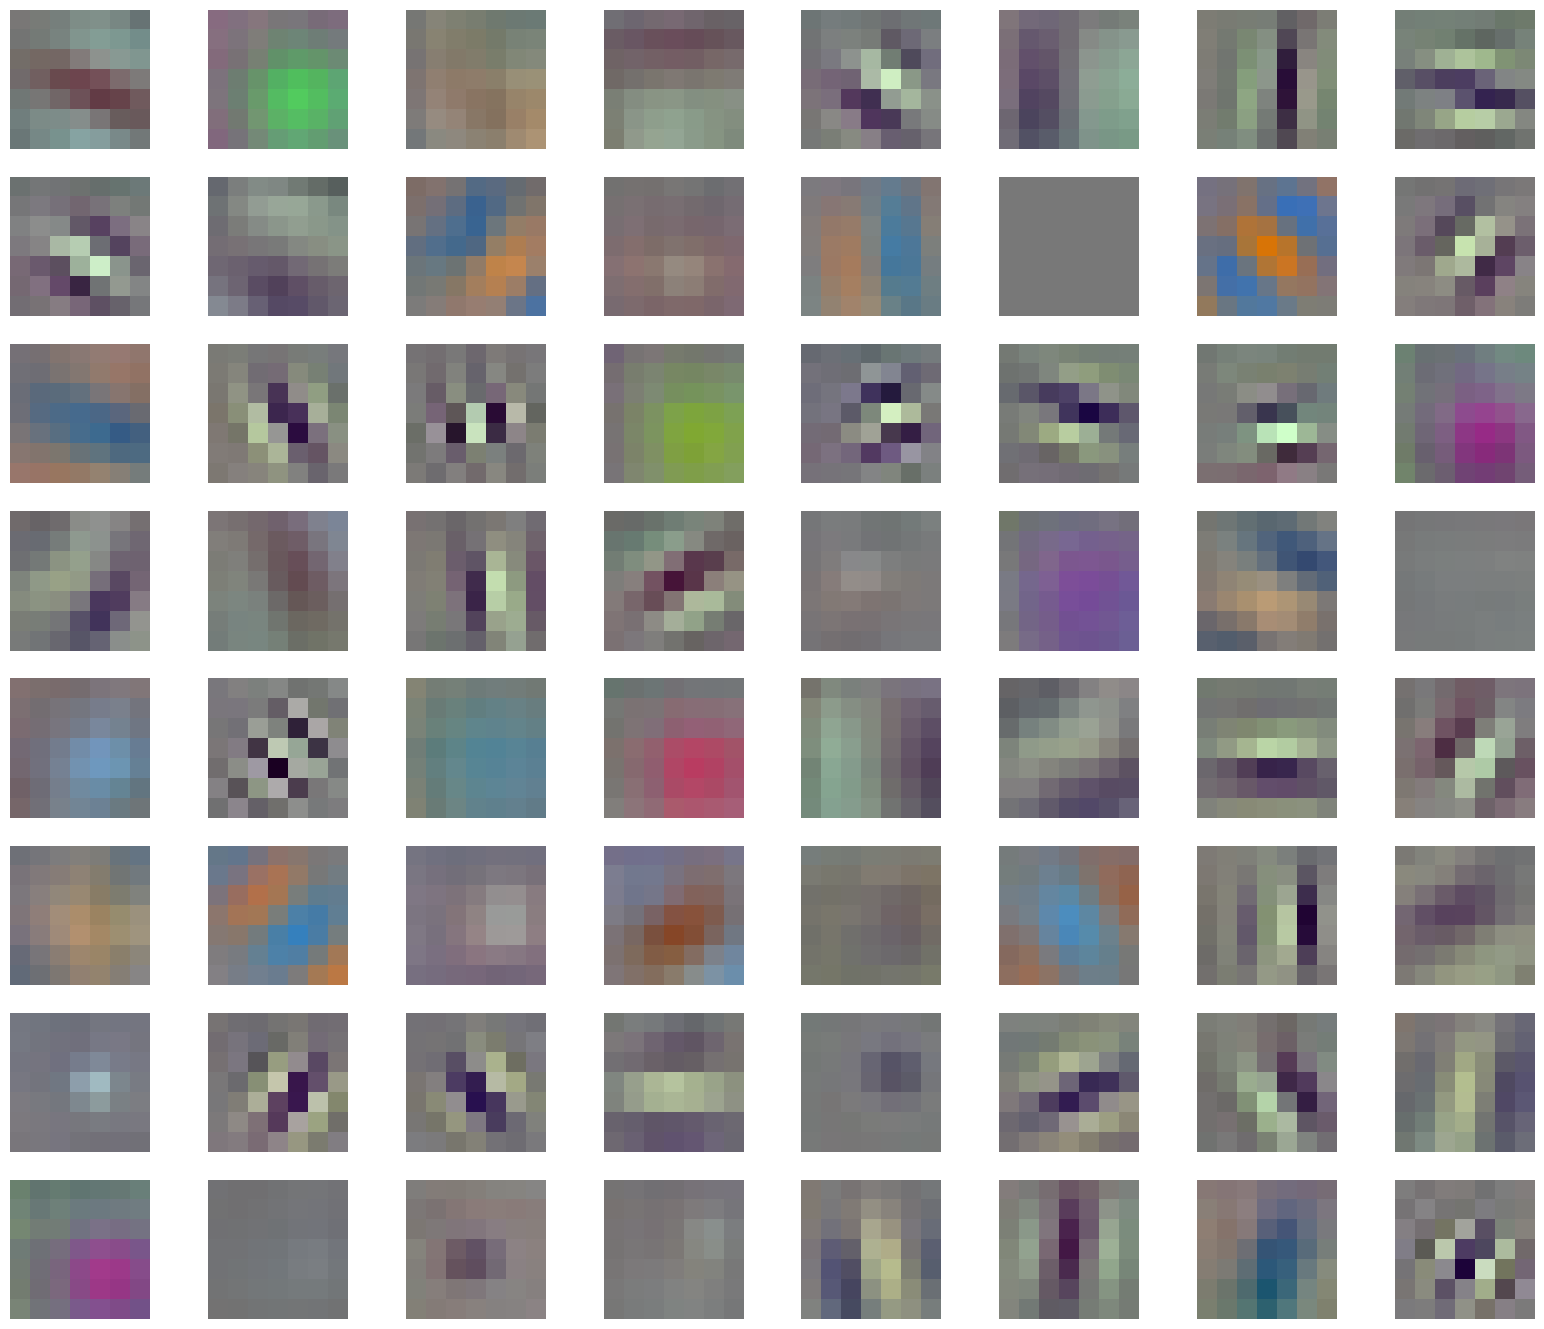

In [103]:
# Ensure it's in evaluation mode for visualization
model_res50.eval()  # This changes the model to evaluation mode

# Get the weights of the first convolutional layer
weights = model_res50.conv1.weight.data.cpu()

# Normalize the weights for better visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())
print(weights[0])
print(weights[0].permute(1, 2, 0))
# Plot the first few filters
plt.figure(figsize=(20, 17))
for i in range(64):  # Let's visualize 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(weights[i].permute(1, 2, 0))  # Rearrange the dimensions
    plt.axis('off')
plt.show()

## Inference

In [18]:
validation_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images\224'
dataset_validation = Lyft_experimental_CustomDataset(validation_images_dir, target_category_name = "pedestrian", required_size=224)
dataloader_validation = DataLoader(dataset, batch_size=32, shuffle=True)

In [109]:
# sizes = [224]
# dynamic_transform(validation_images_dir, sizes)

In [19]:
# window_size = 224
#Our test data/images will be preselected to only data that we know contains at least one instance of the target class.
#Additionally, we will only account for preexisting bounding boxes that are also of the target class. This simplifies the initial task, and can be expanded to include non-target class boxes for additional testing in the future.
#test_data will be of the form below which is a dictionaries with key as the img_id_name and the value as a list of 1:n dictionaries where each dictionary has two elements for the original and predicted bounding box whose
#values are simply the coordinates of the bounding box in image coordinates.
#Remember: All of our bounding_box_original boxes will be from the set of only the boxes of the target class.
#test_data = {img_id_name: [{bounding_box_original: np.array(), bounding_box_predicted: np.array()},
#                       {bounding_box_original: np.array(), bounding_box_predicted: np.array()}]}

# for img_id_name, box_list in test_data:
    #split up the image into "window_size" subsections. Input windows are 1024x1224, so window size of 224 will not split evenly. How to handle non-even splits for convolution/sliding windows?
    #for each subsection:
        #feed the subsection into my network and get a binary prediction: 1 - yes, this is the target class (pedestrain) or 0, no this is not the target class.

        #if we found a target class:
            #target_box = coordinates of the image that pertain to subsection that has a positive prediction
            

IndentationError: expected an indented block (1927823325.py, line 2)

In [19]:
# Set the model to evaluation mode
model_res50.eval()

running_loss = 0.0
running_corrects = 0
total_samples = 0
running_true_positives = 0
running_false_positives = 0
running_false_negatives = 0

# Disable gradient calculations as they are not needed for validation
with torch.no_grad():
    for inputs, labels in dataloader_validation:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_res50(inputs)
        loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        # Calculate True Positives, False Positives, False Negatives
        for i in range(len(labels)):
            if preds[i] == labels[i] == 1:  # True Positive
                running_true_positives += 1
            elif preds[i] == 1 and labels[i] == 0:  # False Positive
                running_false_positives += 1
            elif preds[i] == 0 and labels[i] == 1:  # False Negative
                running_false_negatives += 1


# Calculate the average loss and accuracy over the validation set
val_loss = running_loss / total_samples
val_acc = running_corrects.double() / total_samples
# Calculate Precision, Recall, and F1 Score after the loop
precision = running_true_positives / (running_true_positives + running_false_positives) if (running_true_positives + running_false_positives) > 0 else 0
recall = running_true_positives / (running_true_positives + running_false_negatives) if (running_true_positives + running_false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Validation Loss: {val_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1_score:.4f} Acc: {val_acc:.4f}')


Validation Loss: 0.0389 Precision: 0.9604 Recall: 0.9616 F1 Score: 0.9610 Acc: 0.9868


In [111]:
checkpoint = {
    'model_state_dict': model_res50.state_dict(),
    'validation_loss': val_loss,
    'validation_accuracy': val_acc
}

# Save the checkpoint
torch.save(checkpoint, 'model_res50_validation_checkpoint.pth')

# Object Detection

### Heatmap. Note: We use both training and validation data to aggregate a heat map. The heat map itelf isn't involved as a parameter in the model. This is simply just using a greater sample size to determine the places within the full sized images that are most and least likely for pedestrians to occur. This way, we can decrease the image space that our model will scan for each image.

In [4]:
train_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_logs_tokens_pedestrian.json"
val_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_logs_tokens_pedestrian.json"
with open(train_path, 'r') as file:
    train_pedestrians = json.load(file)
with open(val_path, 'r') as file:
    val_pedestrians = json.load(file)

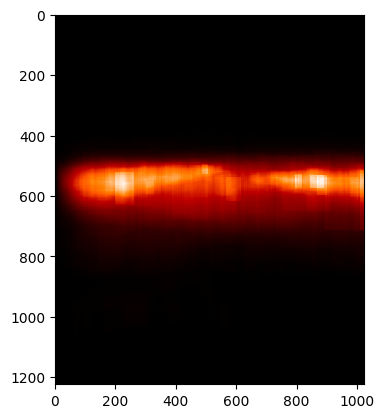

In [26]:
# Initialize heatmap grid
heatmap = np.zeros((1224, 1024))

for filename, coords in train_pedestrians.items():
    
    box_coords = coords[0]
    
    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

for filename, coords in val_pedestrians.items():

    box_coords = coords[0]

    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

# Normalize the heatmap
heatmap = heatmap / np.max(heatmap)

# Plot the heatmap
plt.imshow(heatmap, cmap='gist_heat', interpolation='nearest')
plt.show()

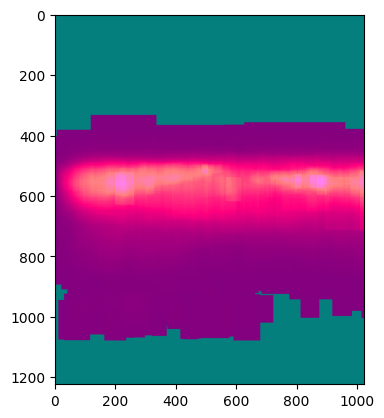

In [27]:
# Create a mask for any non-zero values
outlier_mask = heatmap > 0

# Plot the heatmap with non-zero values highlighted
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.imshow(outlier_mask, cmap='cool', alpha=0.5) # overlaying with a different color
plt.show()

## Import FasterRCNN model.

In [5]:
# Load a pre-trained fasterrcnn_mobilenet_v3_large_fpn model
model_fastercnn = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one for binary classification (background + pedestrian)
num_classes = 2  # 1 class (pedestrian) + background
# Get the number of input features for the classifier
in_features = model_fastercnn.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one (note: this automatically changes the anchor generator to match the backbone)
model_fastercnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_fastercnn = model_fastercnn.to(device)

cuda:0


## Create our Dataset and Dataloader objects for object detection

In [8]:
def collate_fn(batch):
    """
    Custom collate function for handling varying sizes of bounding boxes and labels.
    """
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), {}

    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Stack images as they should have the same size
    # Do not stack targets as they can have varying sizes
    return images, targets

images_base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images"
train_data_dict_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_merged.json'
with open(train_data_dict_path, "r") as file:
    train_data_dict = json.load(file)
dataset_training_detection = Lyft_binary_object_detection_CustomDataset(train_data_dict, images_base_path=images_base_path, transform=None, random_sample=None, positive_imgs_only=True)
# Use the custom collate function in the DataLoader
batch_size=10
dataloader_training_detection = DataLoader(dataset_training_detection, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print("total number of training batches to anticipate: ", len(dataset_training_detection)/batch_size, "Dataset total length: ", len(dataset_training_detection))

validation_data_dict_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_merged.json'
with open(validation_data_dict_path, "r") as file:
    validation_data_dict = json.load(file)
dataset_validation_detection = Lyft_binary_object_detection_CustomDataset(validation_data_dict, images_base_path=images_base_path, transform=None, random_sample=None, positive_imgs_only=True)
# Use the custom collate function in the DataLoader
batch_size=10
dataloader_validation_detection = DataLoader(dataset_validation_detection, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print("total number of validation batches to anticipate: ", len(dataset_validation_detection)/batch_size, "Dataset total length: ", len(dataset_validation_detection))
print(dataloader_validation_detection.dataset.file_names)

total number of training batches to anticipate:  331.2 Dataset total length:  3312
total number of validation batches to anticipate:  621.9 Dataset total length:  6219
dict_keys(['host-a004_cam0_1232817652451064006.jpeg', 'host-a004_cam3_1232817653800897006.jpeg', 'host-a004_cam1_1232825405634300006.jpeg', 'host-a004_cam3_1232817653600897006.jpeg', 'host-a004_cam2_1232825406817652006.jpeg', 'host-a004_cam1_1232825406034300006.jpeg', 'host-a004_cam2_1232825406417652006.jpeg', 'host-a004_cam1_1232825405834300006.jpeg', 'host-a004_cam2_1232825406617652006.jpeg', 'host-a004_cam1_1232825405434300006.jpeg', 'host-a004_cam1_1232817652634300006.jpeg', 'host-a004_cam0_1232817652251064006.jpeg', 'host-a011_cam2_1233087928217605006.jpeg', 'host-a011_cam2_1233087928017605006.jpeg', 'host-a011_cam1_1233087927834517006.jpeg', 'host-a011_cam1_1233087927434517006.jpeg', 'host-a011_cam1_1233087927634517006.jpeg', 'host-a102_cam2_1241468929483330006.jpeg', 'host-a101_cam1_1241886992566660006.jpeg', 'hos

## Train

In [13]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1 (list of floats): bounding box in format [x_min, y_min, x_max, y_max].
    box2 (list of floats): bounding box in format [x_min, y_min, x_max, y_max].

    Returns:
    float: IoU of box1 and box2.
    """

    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is no overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate combined area
    total_area = box1_area + box2_area - intersection_area

    # Compute IoU
    iou = intersection_area / total_area

    return iou

In [14]:
validation_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup"
validation_filename = r"validation_merged.json"
validation_input_path = os.path.join(validation_path, validation_filename)
with open(validation_input_path, "r") as file:
    validation_dict = json.load(file)

# Before starting your training loop
torch.cuda.empty_cache()  # Clear cache if any

# Training loop
num_epochs = 5
iou_threshold = 0.5  # Example threshold
optimizer = torch.optim.Adam(model_fastercnn.parameters(), lr=0.001)  # Example optimizer

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for the epoch
    model_fastercnn.train()  # Set model to training mode
    running_loss = 0.0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    batch_i = 0

    for images, targets in dataloader_training_detection:
        batch_start_time = time.time()
        print("On batch: ", batch_i)
        batch_i += 1
        
        images = images.to(device)
        targets_on_device = []
        for target in targets:
            target_on_device = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in target.items()}
            targets_on_device.append(target_on_device)


        # Forward pass
        optimizer.zero_grad()  # Clear existing gradients
        loss_dict = model_fastercnn(images, targets_on_device)  # Forward pass
        losses = sum(loss for loss in loss_dict.values())  # Sum up all losses

        # Backward pass and optimize
        losses.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        running_loss += losses.item()
        batch_duration = time.time() - batch_start_time  # Calculate duration for the batch
        print(f'Batch Duration: {batch_duration:.2f} seconds')

    # Evaluation mode for inference
    model_fastercnn.eval()
    inference_batch_i = 0
    with torch.no_grad():
        for images, targets in dataloader_validation_detection:
            inference_batch_start_time = time.time()
            print("On inference batch: ", inference_batch_i)
            inference_batch_i += 1
            
            images = images.to(device)
            predictions = model_fastercnn(images)
            filenames = dataloader_validation_detection.dataset.file_names
            try:
                # Update the dictionary with predictions
                for filename, target, prediction in zip(filenames, targets, predictions):
                    predicted_boxes = prediction['boxes'].cpu().numpy().tolist()
                    predicted_labels = prediction['labels'].cpu().numpy().tolist()
                    print("predicted boxex: ", predicted_boxes)
                    print("predicted labels: ", predicted_labels)

                    if "predicted_boxes" in validation_dict.keys():
                        validation_dict[filename]['predicted_boxes'].extend(predicted_boxes)
                    else:
                        validation_dict[filename]['predicted_boxes'] = predicted_boxes
                    if "predicted_labels" in validation_dict.keys():
                        validation_dict[filename]['predicted_labels'].extend(predicted_labels)
                    else:
                        validation_dict[filename]['predicted_labels'] = predicted_labels
            except Exception as e:
                print(f"An error occurred: {e}")

                
            for target, prediction in zip(targets, predictions):
                ground_truth_boxes = target["boxes"]
                predicted_boxes = prediction["boxes"]

                if len(predicted_boxes) > 0:
                    iou = calculate_iou(predicted_boxes[0], ground_truth_boxes[0])

                    if iou >= iou_threshold:
                        total_true_positives += 1
                    else:
                        total_false_positives += 1
                else:
                    total_false_negatives += 1
            
            inference_batch_duration = time.time() - inference_batch_start_time  # Calculate duration for the batch
            print(f'Inference Batch Duration: {inference_batch_duration:.2f} seconds')

    # Calculate metrics after each epoch
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    model_fastercnn.train()  # Set back to training mode

    epoch_loss = running_loss / len(dataloader_training_detection.dataset)
    epoch_duration = time.time() - epoch_start_time  # Calculate duration for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1_score:.4f}, Duration: {epoch_duration:.2f} seconds")

    #Save after each epoch.
    model_fastercnn_dict = model_fastercnn.state_dict()
    torch.save(model_fastercnn_dict, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\model_fastercnn_12_2_23_00_00")

    #Output our resulting validation data dict with the predictions appended to it. Recall that this is the initial data dict that is read in in our dataset_training_detection.
    predictions_filename = r"validation_merged_w_predictions.json"
    predictions_output_path = os.path.join(validation_path, predictions_filename)
    with open(predictions_output_path, "w") as outfile:
        json.dump(validation_dict, outfile)

On batch:  0
Batch Duration: 29.34 seconds
On batch:  1
Batch Duration: 34.47 seconds
On batch:  2
Batch Duration: 37.97 seconds
On batch:  3
Batch Duration: 3.11 seconds
On inference batch:  0
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
Inference Batch Duration: 9.31 seconds
On inference batch:  1
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted boxex:  []
predicted labels:  []
predicted box

KeyboardInterrupt: 

In [7]:
model_fastercnn_dict = model_fastercnn.state_dict()
torch.save(model_fastercnn_dict, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\model_fastercnn_12_1_23_00_00")